<a href="https://colab.research.google.com/github/SeongDeokKo/Replication/blob/master/Krusell_Smith_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Running on Google Colab
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia (the Jupyter kernel for Julia) and other packages. You can update `JULIA_VERSION` and the other parameters, if you know what you're doing. Installation takes 2-3 minutes.
3. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the _Checking the Installation_ section.

* _Note_: If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2 and 3.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools PyCall PyPlot QuantEcon JLD2 Roots Random LinearAlgebra Plots Distributions Dierckx Optim Roots GLM StatsBase Parameters Interpolations"
JULIA_PACKAGES_IF_GPU="CUDA"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.6.0 on the current Colab Runtime...
2021-07-13 04:12:36 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.6/julia-1.6.0-linux-x86_64.tar.gz [112838927/112838927] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package PyCall...
Installing Julia package PyPlot...
Installing Julia package QuantEcon...
Installing Julia package JLD2...
Installing Julia package Roots...
Installing Julia package Random...
Installing Julia package LinearAlgebra...
Installing Julia package Plots...
Installing Julia package Distributions...
Installing Julia package Dierckx...
Installing Julia package Optim...
Installing Julia package Roots...
Installing Julia package GLM...
Installing Julia package StatsBase...
Installing Julia package Parameters...
Installing Julia package Interpolations...
Installing Julia package CUDA...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share

In [1]:
versioninfo()

Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, broadwell)
Environment:
  JULIA_NUM_THREADS = 4


In [2]:
using LinearAlgebra
using QuantEcon
using Roots
using Dierckx
using Optim
using Parameters
using StatsBase
using GLM
using Interpolations
using Random
using JLD2

In [3]:
const β = 0.99
const δ = 0.025
const σ = 1
const α = 0.36
const zg = 1.01
const zb = 0.99
const ug = 0.04
const ub = 0.1
const nz = 2 # the number of aggregate states
const zgrid = [zg, zb] # TFP grid
const T = 3000 # final time period
const T0 = 500 # discard all the points before this period
const ne = 2
# transition probabilities
const πgg = 7/8 # good -> good
const πgb = 1/8 # good -> bad
const πbg = 1/8 # bad -> good
const πbb = 7/8 # bad -> bad
# constant unemployment rates in each state
const ug = 0.04
const ub = 0.1
const L_bar = 0.3271 # Krusell Smith 논문에 이렇게 주어짐. 
const Lgrid = [1-ug, 1-ub] * L_bar # Aggregate Labor
const mu = 0.15 # Fractrion of 

0.15

In [4]:
kss=((1/β-(1-δ))/α)^(1/(α-1)) * L_bar

12.426284832329591

In [ ]:
α*zg*Kval^(α-1)*(Lgrid[1])^(1-α) - δ

In [20]:
r_init = α*kss^(α-1) * L_bar^(1-α) - δ
w_init = (1-α) * kss^α * (L_bar)^(-α)

2.37059763941781

In [5]:
#=P = [P_GEGE P_GEGU P_GEBE P_GEBU ;
      P_GUGE P_GUGU P_GUBE P_GUBU ;
      P_BEGE P_BEGU P_BEBE P_BEBU ;
      P_BUGE P_BUGU P_BUBE P_BUBU ] 
=##

P = zeros(4,4); # Transition Matrix 저장할 곳 
P[2,2] = 1/3 ;
P[2,1] = 7/8 - P[2,2]
P[4,4] = 0.6 ;
P[4,3] = 7/8 - 0.6
P[2,4] = 3/28 ; 
P[2,3] = 1/8 - P[2,4]
P[4,2] = 1/28 ; 
P[4,1] = 1/8 - 1/28
RHS12 =  ug - ug * P[2,2]/πgg ; 
LHS12 = (1-ug)/πgg
P[1,2] = RHS12/LHS12 ; 
P[1,1] = 7/8 - P[1,2]
RHS14 = ub - ug*P[2,4]/πgb ; 
LHS14 = (1-ug)/πgb
P[1,4] = RHS14/LHS14 ; 
P[1,3] = 1/8 - P[1,4]
RHS32 = 0.04 - P[4,2]*8*0.1 ; 
LHS32 = 0.9/(1/8)
P[3,2] = RHS32/LHS32 ; 
P[3,1] = 1/8 - P[3,2]
RHS34 = 0.1 - P[4,4]*8/7*0.1 ; 
LHS34 = 0.9/(7/8)
P[3,4] = RHS34/LHS34 ; 
P[3,3] = 7/8 - P[3,4];


In [6]:
Random.seed!(12345)

MersenneTwister(12345)

In [7]:
using Distributions
function Generate_Shock(T::Int64,NH::Int64)
    zseq = zeros(Int64,T)
    zseq[1] = 0 # arbitrarily chosen
    
    P_GGEE = P[1,1] /(P[1,1] + P[1,2] )
    P_GBEE = P[1,3] /(P[1,3] + P[1,4] )
    P_GGUE = P[2,1] /(P[2,1] + P[2,2] )
    P_GBUE = P[2,3] /(P[2,3] + P[2,3] )

    P_BGEE = P[3,1] /(P[3,1] + P[3,2] ) 
    P_BBEE = P[3,3] /(P[3,3] + P[3,4] ) 
    P_BGUE = P[4,1] /(P[4,1] + P[4,2] ) 
    P_BBUE = P[4,3] /(P[4,4] + P[4,4] ) 
    for iter in 2:T
        if zseq[iter-1] == 1
            zseq[iter] = sample([1, 0], weights([πgg, πgb]))
        elseif zseq[iter-1] == 0
            zseq[iter] = sample([1, 0], weights([πbg, πbb]))
        end
    end

    Zt = zeros(Float64,T);
    for t in eachindex(zseq)
        if zseq[t] == 1
            Zt[t] = zgrid[1]
        else
            Zt[t] = zgrid[2]
        end 
    end

    Ind_shock = zeros(Int64,NH,T)
    for NH_idx = 1:NH
        u = rand(Uniform(0,1))
        if zseq[1] == 0
            if u < ub
                Ind_shock[NH_idx,1] = 0
            else
                Ind_shock[NH_idx,1] = 1
            end
        else zseq[1] == 1
            if u < ug
                Ind_shock[NH_idx,1] = 0
            else
                Ind_shock[NH_idx,1] = 1
            end
        end
    end
    for t = 2:T
        for NH_idx = 1:NH
            u = rand(Uniform(0,1))
            ## Good To Good 
            if zseq[t-1] == 1 && zseq[t] == 1
                if Ind_shock[NH_idx,t-1] == 1
                    if u < P_GGEE 
                        Ind_shock[NH_idx,t] = 1
                    else 
                        Ind_shock[NH_idx,t] = 0
                    end
                else 
                    if u < P_GGUE 
                        Ind_shock[NH_idx,t] = 1
                    else 
                        Ind_shock[NH_idx,t] = 0
                    end
                end
            elseif zseq[t-1] == 1 && zseq[t] == 0
            ## Good To Bad
                if Ind_shock[NH_idx,t-1] == 1
                    if u < P_GBEE
                        Ind_shock[NH_idx,t] = 1
                    else 
                        Ind_shock[NH_idx,t] = 0
                    end
                else 
                    if u < P_GBUE
                        Ind_shock[NH_idx,t] = 1
                    else 
                        Ind_shock[NH_idx,t] = 0
                    end
                end
            elseif zseq[t-1] == 0 && zseq[t] == 1
            ## Bad to Good
                if Ind_shock[NH_idx,t-1] == 1
                    if u < P_BGEE
                        Ind_shock[NH_idx,t] = 1
                    else 
                        Ind_shock[NH_idx,t] = 0
                    end
                else 
                    if u < P_BGUE 
                        Ind_shock[NH_idx,t] = 1
                    else 
                        Ind_shock[NH_idx,t] = 0
                    end
                end
            else
            ## Bad to Bad
                if Ind_shock[NH_idx,t-1] == 1
                    if u < P_BBEE
                        Ind_shock[NH_idx,t] = 1
                    else 
                        Ind_shock[NH_idx,t] = 0
                    end
                else 
                    if u < P_BBUE 
                        Ind_shock[NH_idx,t] = 1
                    else 
                        Ind_shock[NH_idx,t] = 0
                    end
                end
            end
        end
    end

    return zseq, Zt , Ind_shock

end

Generate_Shock (generic function with 1 method)

In [8]:
NH = 10_000;
zseq, Zt , Ind_shock=Generate_Shock(T,NH);

In [9]:
function U(x::Float64)
    if x < 0
        return -Inf
    end
    return log(x)
end
function U(x::Int64)
    if x < 0
        return -Inf
    end
    return log(x)
end

U (generic function with 2 methods)

In [10]:
# capital grid
Kmin = kss * 0.65
Kmax = kss * 1.35
nK = 4
Kgrid = range(Kmin, Kmax, length=nK) |> collect ;

In [15]:
amin=0;                #   % minimum grid-value of capitala
amax=1000;             #   % maximum grid-value of capital
na= 100;                #% number of grid points
x = range(0,0.5,length = na);# % generate a grid of ngridk points on [0,0.5] #   % interval  
y = x.^7/maximum(x).^7

agrid = amin .+ (amax - amin) * y;

In [16]:
# 초기값 
Coef= [0.0 1.0;  0.0 1.0]

2×2 Matrix{Float64}:
 0.0  1.0
 0.0  1.0

In [31]:
function Neville(x::Array{Float64}, y::Array{Float64}, x0::Float64, N::Int64)   
  
    Q = zeros(N,N)
    Q[:,1] .= y
  
    for i in 2:N 
        for j in 2:i
            Q[i,j] = ((x0 - x[i-j+1]) * Q[i,j-1] - (x0 - x[i]) * Q[i-1,j-1]) / (x[i] - x[i-j+1])
        end
    end
    return Q[N,N]
end
  
function Neville(x::Array{Float64}, y::Array{Float64}, x0::Int64, N::Int64)   
  
    Q = zeros(N,N)
    Q[:,1] .= y
    for i in 2:N 
        for j in 2:i
            Q[i,j] = ((x0 - x[i-j+1]) * Q[i,j-1] - (x0 - x[i]) * Q[i-1,j-1]) / (x[i] - x[i-j+1])
        end
    end
    return Q[N,N]
end

Neville (generic function with 2 methods)

In [84]:
function TV( V::Array{Float64,4},
    Kgrid::Array{Float64,1},
    agrid::Array{Float64,1},
    zgrid::Array{Float64,1},
    P::Array{Float64,2},
    na::Int64,
    nK::Int64,
    ne::Int64,
    nz::Int64, Coef::Array{Float64,2},U,Neville; ITP = "Cubic")

    Vnew = copy(V)
    gg = zeros(na,nK,nz,ne)

### Where to assign Interpolation Value
    V_GE = zeros(na);
    V_GU = zeros(na);
    V_BE = zeros(na);
    V_BU = zeros(na);
###

    for (Kidx, Kval) in enumerate(Kgrid)

        r_g = α*zg*Kval^(α-1)*(Lgrid[1])^(1-α) - δ
        w_g = (1-α) * zg * Kval^α * (Lgrid[1])^(-α)
            
        r_b = α*zb*Kval^(α-1)*(Lgrid[2])^(1-α) - δ
        w_b = (1-α) * zb * Kval^α * (Lgrid[2])^(-α)

        #tau_g = mu * ug / Lgrid[1]
        #tau_b = mu * ub / Lgrid[2]

        K_Prime_g = ( Coef[1,1] + Coef[1,2]*log(Kval) ) |> exp
        K_Prime_b = ( Coef[2,1] + Coef[2,2]*log(Kval) ) |> exp
        # 여기 파트에서 
              
        K_Prime_g = min(max(K_Prime_g, Kgrid[1]), Kgrid[end])
        K_Prime_b = min(max(K_Prime_b, Kgrid[1]), Kgrid[end])
        # Use Neville Interpolation

        V_BU = map( x ->  Neville(Kgrid, V[x,:,1,1], K_Prime_b , nK), 1:na)
        V_BE = map( x ->  Neville(Kgrid, V[x,:,1,2], K_Prime_b , nK), 1:na)
        V_GU = map( x ->  Neville(Kgrid, V[x,:,2,1], K_Prime_g , nK), 1:na)
        V_GE = map( x ->  Neville(Kgrid, V[x,:,2,2], K_Prime_g , nK), 1:na)

        # na, nK, nz, ne
        # Use Cubic Spline

        if ITP == "Linear"
            V_Next_GE = LinearInterpolation( agrid, V_GE) 
            V_Next_GU = LinearInterpolation( agrid, V_GU) 
            V_Next_BE = LinearInterpolation( agrid, V_BE) 
            V_Next_BU = LinearInterpolation( agrid, V_BU)
        else #Cubic
            V_Next_GE = Spline1D( agrid, V_GE ,k = 3) 
            V_Next_GU = Spline1D( agrid, V_GU ,k = 3) 
            V_Next_BE = Spline1D( agrid, V_BE ,k = 3) 
            V_Next_BU = Spline1D( agrid, V_BU ,k = 3) 
        end 
        for a_idx in eachindex(agrid)

            ## Bad && Unemployed

            obj_BU(a_prime) = -(  U(  (1 + r_b) * agrid[a_idx] - a_prime + eps() ) + 
                β* ( P[4,1] * V_Next_GE(a_prime) + P[4,2] * V_Next_GU(a_prime) +
                P[4,3] * V_Next_BE(a_prime) + P[4,4] * V_Next_BU(a_prime))  )
            ubd_BU = min.( ( 1 + r_b )*agrid[a_idx], agrid[end] )
            res_BU = optimize(obj_BU, agrid[1], ubd_BU)       
            gg[a_idx,Kidx,1,1] = res_BU.minimizer
            Vnew[a_idx,Kidx,1,1] = (-1) * res_BU.minimum     

            ## Bad && Employed

            obj_BE(a_prime) = -(  U( w_b * L_bar + (1 + r_b) * agrid[a_idx] - a_prime + eps() ) + 
                β * ( P[3,1] * V_Next_GE(a_prime) + P[3,2] * V_Next_GU(a_prime) +
                P[3,3] * V_Next_BE(a_prime) + P[3,4] * V_Next_BU(a_prime))    )
            ubd_BE = min.( w_b * L_bar + (1 + r_b)*agrid[a_idx], agrid[end] )
            res_BE = optimize(obj_BE, agrid[1], ubd_BE)       
            gg[a_idx,Kidx,1,2] = res_BE.minimizer
            Vnew[a_idx,Kidx,1,2] = (-1) * res_BE.minimum  

            ## Good && Unemployed

            obj_GU(a_prime) = -(  U(  (1 + r_g) * agrid[a_idx] - a_prime + eps() ) + 
                β* ( P[2,1] * V_Next_GE(a_prime) + P[2,2] * V_Next_GU(a_prime) +
                P[2,3] * V_Next_BE(a_prime) + P[2,4] * V_Next_BU(a_prime))  )
            ubd_GU = min.( (1 + r_g)*agrid[a_idx], agrid[end] )
            res_GU = optimize(obj_GU, agrid[1], ubd_GU)       
            gg[a_idx,Kidx,2,1] = res_GU.minimizer
            Vnew[a_idx,Kidx,2,1] = (-1) * res_GU.minimum      


            ## Good && Employed
            obj_GE(a_prime) = -(  U( w_g*L_bar + (1 + r_g) * agrid[a_idx] - a_prime + eps() ) + 
                β* ( P[1,1] * V_Next_GE(a_prime) + P[1,2] * V_Next_GU(a_prime) +
                P[1,3] * V_Next_BE(a_prime) + P[1,4] * V_Next_BU(a_prime))   )
            ubd_GE = min.( w_g * L_bar + (1 + r_g)*agrid[a_idx], agrid[end] )
            res_GE = optimize(obj_GE, agrid[1], ubd_GE)       
            gg[a_idx,Kidx,2,2] = res_GE.minimizer
            Vnew[a_idx,Kidx,2,2] = (-1) * res_GE.minimum
        end
    end

    return Vnew, gg
end

TV (generic function with 1 method)

In [85]:
function TV_Howard( V::Array{Float64,4},
    gg::Array{Float64,4},
    Kgrid::Array{Float64,1},
    agrid::Array{Float64,1},
    zgrid::Array{Float64,1},
    P::Array{Float64,2},
    na::Int64,
    nK::Int64,
    ne::Int64,
    nz::Int64, 
    Coef::Array{Float64,2},
    U,Neville; ITP = "Cubic")

    Vnew = copy(V)
    ### Where to assign Interpolation Value
    V_GE = zeros(na)
    V_GU = zeros(na)
    V_BE = zeros(na)
    V_BU = zeros(na)
    ####################################

    for (Kidx, Kval) in enumerate(Kgrid)
            
        r_g = α*zg*Kval^(α-1)*(Lgrid[1])^(1-α) - δ
        w_g = (1-α) * zg * Kval^α * (Lgrid[1])^(-α)
            
        r_b = α*zb*Kval^(α-1)*(Lgrid[2])^(1-α) - δ
        w_b = (1-α) * zb * Kval^α * (Lgrid[2])^(-α)

        #tau_g = mu * ug / Lgrid[1]
        #tau_b = mu * ub / Lgrid[2]
            
        K_Prime_g = ( Coef[1,1] + Coef[1,2]*log(Kval) ) |> exp
        K_Prime_b = ( Coef[2,1] + Coef[2,2]*log(Kval) ) |> exp
        # 여기 파트에서 
              
        K_Prime_g = min(max(K_Prime_g, Kgrid[1]), Kgrid[end])
        K_Prime_b = min(max(K_Prime_b, Kgrid[1]), Kgrid[end])
        
        # Use Neville Interpolation

        V_BU = map( x ->  Neville(Kgrid, V[x,:,1,1], K_Prime_b , nK), 1:na)
        V_BE = map( x ->  Neville(Kgrid, V[x,:,1,2], K_Prime_b , nK), 1:na)
        V_GU = map( x ->  Neville(Kgrid, V[x,:,2,1], K_Prime_g , nK), 1:na)
        V_GE = map( x ->  Neville(Kgrid, V[x,:,2,2], K_Prime_g , nK), 1:na)

        if ITP == "Linear"
            V_Next_GE = LinearInterpolation( agrid, V_GE) 
            V_Next_GU = LinearInterpolation( agrid, V_GU) 
            V_Next_BE = LinearInterpolation( agrid, V_BE) 
            V_Next_BU = LinearInterpolation( agrid, V_BU)
        else #Cubic
            V_Next_GE = Spline1D( agrid, V_GE ,k = 3) 
            V_Next_GU = Spline1D( agrid, V_GU ,k = 3) 
            V_Next_BE = Spline1D( agrid, V_BE ,k = 3) 
            V_Next_BU = Spline1D( agrid, V_BU ,k = 3) 
        end  
    
        # Objective Functions 
    
        # zidx = 1 이면 오늘 Good / = 2 이면 오늘 Bad
        
        ## Bad && Unemployed

        Vnew[:,Kidx,1,1] = map( x ->  (  U( (1 + r_b ) * agrid[x] - gg[x,Kidx,1,1] + eps() ) + 
            β * ( P[4,1] * V_Next_GE(gg[x,Kidx,1,1]) + P[4,2] * V_Next_GU(gg[x,Kidx,1,1]) +
            P[4,3] * V_Next_BE(gg[x,Kidx,1,1]) + P[4,4] * V_Next_BU(gg[x,Kidx,1,1]) ) ) , 1:na) 

        ## Bad && Employed

        Vnew[:,Kidx,1,2] = map( x ->  (  U( w_b * L_bar  + (1 + r_b) * agrid[x] - gg[x,Kidx,1,2] + eps() ) + 
            β * ( P[3,1] * V_Next_GE( gg[x,Kidx,1,2] ) + P[3,2] * V_Next_GU( gg[x,Kidx,1,2] ) +
            P[3,3] * V_Next_BE( gg[x,Kidx,1,2] ) + P[3,4] * V_Next_BU( gg[x,Kidx,1,2] ) ) ) , 1:na  ) 

        ## Good && Unemployed    
        Vnew[:,Kidx,2,1] = map( x -> (  U((1 + r_g) * agrid[x] - gg[x,Kidx,2,1] + eps() ) + 
            β * ( P[2,1] * V_Next_GE(gg[x,Kidx,2,1]) + P[2,2] * V_Next_GU(gg[x,Kidx,2,1]) +
            P[2,3] * V_Next_BE(gg[x,Kidx,2,1]) + P[2,4] * V_Next_BU(gg[x,Kidx,2,1])) )  , 1:na )    

        ## Good && Employed
            
        Vnew[:,Kidx,2,2] = map( x ->  (  U( w_g*L_bar + (1 + r_g) * agrid[x] - gg[x,Kidx,2,2] + eps() ) + 
            β * ( P[1,1] * V_Next_GE(gg[x,Kidx,2,2]) + P[1,2] * V_Next_GU(gg[x,Kidx,2,2]) +
            P[1,3] * V_Next_BE( gg[x,Kidx,2,2] ) + P[1,4] * V_Next_BU(gg[x,Kidx,2,2])) )  , 1:na )
    end

    return Vnew
end

TV_Howard (generic function with 1 method)

In [99]:
function VFI( Kgrid::Array{Float64,1},
    zgrid::Array{Float64,1},
    agrid::Array{Float64,1},
    P::Array{Float64,2},
    na::Int64,
    nK::Int64,
    ne::Int64,
    nz::Int64,
    U,Neville,
    Coef::Array{Float64,2},
    TV, TV_Howard ; Howard::Int64 = 1) 
    V_old = zeros(na,nK,nz,ne) # 순서는 철저히 논문의 순서를 따름
    GG_old = zeros(na,nK,nz,ne)
    GG_new = zeros(na,nK,nz,ne)
    err_V = one(Float64)
    err_G = one(Float64)
    iter = zero(Int64)
    V_new = copy(V_old)
    ITP = "Linear"
    while  err_V > 1e-6 

        if iter % Howard == 0  
            V_new, GG_new = TV( V_old,Kgrid,agrid,zgrid,P,na,nK,ne,nz,Coef,U,Neville ; ITP = ITP)
            err_G = (GG_new .- GG_old) .|> abs |> maximum
            copy!(GG_old,GG_new) 
        else 
            V_new = TV_Howard( V_old,GG_old,Kgrid,agrid,zgrid,P,na,nK,ne,nz,Coef,U,Neville ; ITP = ITP)
        end
        err_V = (V_new .- V_old) .|> abs |> maximum
        copy!(V_old,V_new)
        iter += 1

        #if iter >=  Howard * 30 && err_G < 1e-5 
        #    break
        # end

        if iter > 3_000
            println("Something is Weird")
            break
        end
    end

return V_new , GG_new, iter
end

VFI (generic function with 1 method)

In [88]:
function VFI_Test( Kgrid::Array{Float64,1},
    zgrid::Array{Float64,1},
    agrid::Array{Float64,1},
    P::Array{Float64,2},
    na::Int64,
    nK::Int64,
    ne::Int64,
    nz::Int64,
    U,Neville,
    Coef::Array{Float64,2},
    TV, TV_Howard ; Howard::Int64 = 1) 
    V_old = zeros(na,nK,nz,ne) # 순서는 철저히 논문의 순서를 따름
    GG_old = zeros(na,nK,nz,ne)
    GG_new = zeros(na,nK,nz,ne)
    err_V = one(Float64)
    err_G = one(Float64)
    V_new = copy(V_old)
    ITP = "Linear"
    for iter in 0:3000

        if iter > 10
            if iter % Howard == 0  
                V_new, GG_new = TV( V_old,Kgrid,agrid,zgrid,P,na,nK,ne,nz,Coef,U,Neville; ITP = ITP)
                err_G = (GG_new .- GG_old) .|> abs |> maximum
                err_V = (V_new .- V_old) .|> abs |> maximum
                copy!(GG_old,GG_new) 
                copy!(V_old,V_new)
                else 
                    V_new = TV_Howard( V_new,GG_new,Kgrid,agrid,zgrid,P,na,nK,ne,nz,Coef,U,Neville; ITP = ITP)
                    err_V = (V_new .- V_old) .|> abs |> maximum
                copy!(V_old,V_new)
            end
        else 
            V_new, GG_new = TV( V_old,Kgrid,agrid,zgrid,P,na,nK,ne,nz,Coef,U,Neville ; ITP = ITP)
            err_V = (V_new .- V_old) .|> abs |> maximum
            err_G = (GG_new .- GG_old) .|> abs |> maximum
            copy!(GG_old,GG_new)
            copy!(V_old,V_new)
        end
        if iter % 100 == 0 
            println("Iteration is $iter")
            println("Value Function Error is $err_V")
            println("Policy Function Error is $err_G")
        end
        if err_V < 1e-6
            break
        end
    end

return V_new , GG_new
end

VFI_Test (generic function with 1 method)

In [73]:
using BenchmarkTools

In [92]:
function OLS(Y,X ;add_constant = 0 , print = 0 )
    # Input Y : Dependent Variable
    # Input X : Covariates
    # Input add_constant : 1 if we add one vector 
    # Output Estimator      : OLS Estimator 
    # Output SE             : Standard Error 
    # Output SE_robust      : Robust Standard Error 
    # Output sigma2         : Standard Error of Regression
    # Output fitted         : Fitted Value by model 

    Y = reshape(Y,length(Y),1);
    # Reshape data if X is one dimensional vector 
    if ndims(X) == 1
        X = reshape(X,length(X),1);
    end
    
nobs , nvar = size(X);
    
    if add_constant == 1
        X = [ones(nobs,1) X];
        nvar += 1;
    end

df = nobs - nvar;                # Degree of Freedom
XX = X'*X;
estimator = (XX)\(X'*Y);
fitted = X * estimator;
resid = Y - fitted;
SSR = sum(resid.^2);
sigma2 = SSR / (nobs-nvar);
inv_XX = inv(XX);
cov_mat = sigma2*inv_XX ;
SE = sqrt.(diag(cov_mat));

t_stat = estimator ./ SE;

Y_demean = Y .- mean(Y);
R2 = 1-SSR/sum(Y_demean.^2);
log_like = -nobs/2 * (1 + log(2*pi) + log(SSR/nobs) );
DW = sum(diff(resid, dims = 1).^2) ./ SSR; # Durbin Watson 
    if print == 1
    println(" ")
    println("Number of observations   " , nobs  )
    println("Number of regressors     " ,nvar)
    println("result")
        
    println("R-square     :    ", R2)
    println("Variance of s2:    ",sigma2)
    println("Log likelihood:    ",log_like)
    println("D-W statistics:    ",DW)
    end 
    
    return estimator
end

OLS (generic function with 1 method)

In [93]:
update_weight = 0.1
ERR = one(Float64)
iter = 0

0

In [94]:
A_Ind = zeros(NH,T)
A_Ind[:,1] .= kss;
Kt = zeros(T);
Lseq = zeros(T)
for t = 1:T 
    if zseq[t] == 1
        Lseq[t] = Lgrid[1]
    else
        Lseq[t] = Lgrid[2]
    end
end

In [95]:
Yt = zeros(T);

In [96]:
Kt[1] = mean(A_Ind[:,1])
Yt[1] = Zt[1] * Kt[1]^α * Lseq[1]^(1-α)

1.1212664262241143

In [97]:
XX = zeros(T - T0,3);
GG = zeros(na,nK,nz,ne);
VV = zeros(na,nK,nz,ne);

In [ ]:
VFI(  Kgrid, zgrid,agrid, P, na, nK, ne, nz, U, Neville, Coef, TV , TV_Howard ; Howard  = 8) 

In [101]:
for iter = 1:1000
    println("VFI Start")
    ~ ,GG , ~ = VFI(  Kgrid, zgrid,agrid, P, na, nK, ne, nz, U, Neville, Coef, TV , TV_Howard ; Howard  = 8)  
    println("VFI End")

    if ERR < 1e-4
        A_Ind[:,1] = A_Ind[:,end]
        Kt[1] = mean(A_Ind[:,1])
    end
    itp =  LinearInterpolation( ( agrid, Kgrid, [0,1],[0,1]), GG, extrapolation_bc = Line() )
        for t = 2:T
            A_Ind[:,t] = map( x -> itp(A_Ind[x,t-1], Kt[t-1],  zseq[t] , Ind_shock[x,t] ) , 1:NH )
            Kt[t] = mean(A_Ind[:,t])
            Kt[t] = max(Kgrid[1],Kt[t])
            Kt[t] = min(Kgrid[end],Kt[t])
        end 
     
    XX[:,1] = Kt[T0:T-1]
    XX[:,2] = Kt[T0+1:T]
    XX[:,3] = Zt[T0:T-1]
    XX_Good = XX[findall(x->x == 1.01, XX[:,3]),:] 
    XX_Bad = XX[findall(x->x == 0.99, XX[:,3]),:] 
    EST_G = OLS(log.(XX_Good[:,2]), log.(XX_Good[:,1]) ;add_constant = 1 , print = 0 ) 
    EST_B = OLS(log.(XX_Bad[:,2]), log.(XX_Bad[:,1]) ;add_constant = 1 , print = 0 ) 
    New_Coef = [EST_G' ; EST_B']
    println(New_Coef)
    println(Coef)
    
    ERR = (Coef - New_Coef) |> norm 
    println("Iteration is $iter", "   ", "Error level is ", " ", "$ERR")  
    
    Coef = (1-update_weight) * Coef + update_weight * New_Coef
    iter += 1
    if ERR < 1e-6
        break
    end
end

VFI Start
VFI End
[0.24395183656839814 0.9023924039953433; 0.16194370189753376 0.9333960729555228]
[0.0 1.0; 0.0 1.0]
Iteration is 1   Error level is  0.31575558117779334
VFI Start
VFI End
[0.1691873135479757 0.9317986772192783; 0.11265656268324147 0.9527324488151239]
[0.024395183656839816 0.9902392403995344; 0.016194370189753376 0.9933396072955523]
Iteration is 2   Error level is  0.18797328587792053
VFI Start
VFI End
[0.14599973526377674 0.9413257667584528; 0.09664449937027085 0.9593241498001163]
[0.03887439664595341 0.9843951840815088; 0.025840589439102186 0.9892788914475095]
Iteration is 3   Error level is  0.13871298818507943
VFI Start
VFI End
[0.13163240538033846 0.9472495065027697; 0.0862128525618116 0.9636357595783288]
[0.049586930507735744 0.9800882423492032; 0.032920980432219055 0.9862834172827701]
Iteration is 4   Error level is  0.10565407021803327
VFI Start
VFI End
[0.12199499214802328 0.9512191987646953; 0.07930598941427484 0.9664887513916371]
[0.05779147799499602 0.97680

In [105]:
New_Coef = [0.09468402499282103 0.9623960407912501; 0.059195561282779696 0.9748035054369248]

2×2 Matrix{Float64}:
 0.094684   0.962396
 0.0591956  0.974804

In [106]:
Coef - New_Coef |> norm

8.693433420850772e-7

In [110]:
KKt = copy(Kt);

In [111]:
for t = 1:T
    if zseq[t] == 1
        KKt[t] = New_Coef[1,1] + New_Coef[1,2] * log(Kt[t]) |> exp
            else
        KKt[t] = New_Coef[2,1] + New_Coef[2,2] * log(Kt[t]) |> exp
    end
end

In [ ]:
Coef[1,1] |> println 
Coef[1,2] |> println
Coef[2,1] |> println
Coef[2,2] |> println

0.14403978715033403
0.9614761800989985
0.145622366826723
0.9597160782155885


In [112]:
XX[:,1] = Kt[T0:T-1]
    XX[:,2] = Kt[T0+1:T]
    XX[:,3] = Zt[T0:T-1]
    XX_Good = XX[findall(x->x == 1.01, XX[:,3]),:] 
    XX_Bad = XX[findall(x->x == 0.99, XX[:,3]),:] 
    EST_G = OLS(log.(XX_Good[:,2]), log.(XX_Good[:,1]) ;add_constant = 1 , print = 1 ) 
    EST_B = OLS(log.(XX_Bad[:,2]), log.(XX_Bad[:,1]) ;add_constant = 1 , print = 1 ) 

 
Number of observations   1180
Number of regressors     2
result
R-square     :    0.9972730951705339
Variance of s2:    2.3038917198801026e-6
Log likelihood:    5985.3907587956555
D-W statistics:    2.0004773326228347
 
Number of observations   1320
Number of regressors     2
result
R-square     :    0.9949935371959234
Variance of s2:    4.509743974850386e-6
Log likelihood:    6252.12020960706
D-W statistics:    1.6097358171981246


2×1 Matrix{Float64}:
 0.059195561282779696
 0.9748035054369248

In [113]:
using Plots
pyplot()

Plots.PyPlotBackend()

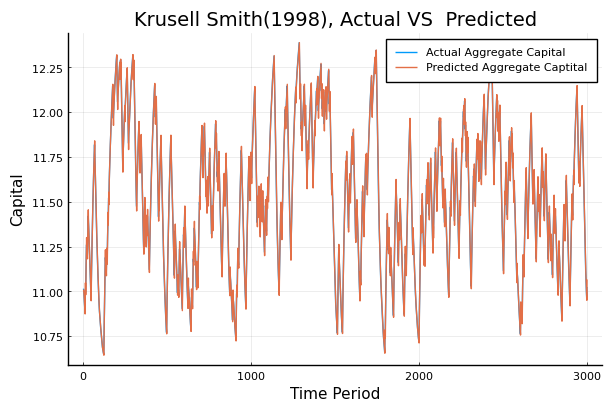

In [119]:
plot(2:T, Kt[2:T], label = "Actual Aggregate Capital", xlabel = "Time Period", ylabel = "Capital")
plot!(2:T,KKt[1:T-1] , label = "Predicted Aggregate Captital")
title!("Krusell Smith(1998), Actual VS  Predicted")
savefig("/content/drive/MyDrive/Figure_KS(1998).png")

In [115]:
function Gini(A_Ind::Array{Float64,1}, NH::Int64; Lorenz = false)
    
    Benchmark = collect(1:1:NH)./NH 
    Sorted_Data = sort(A_Ind)
    Sorted_Data = cumsum(Sorted_Data)/sum(Sorted_Data)
    Upper = zero(Float64)
    Lower = zero(Float64)
    for i = 1:1:NH
        if i == 1
        Upper += (Sorted_Data[i] + 0)*Benchmark[1]/2
        Lower += (Benchmark[i] + 0)*Benchmark[1]/2
        else
        Upper += (Sorted_Data[i] + Sorted_Data[i-1])*Benchmark[1]/2
        Lower += (Benchmark[i] + Benchmark[i-1])*Benchmark[1]/2
        end
    end
    
    if Lorenz == true
        return 1-Upper/Lower , Benchmark, Sorted_Data
    else
        return 1 - Upper/Lower
    end
end

Gini (generic function with 1 method)

In [116]:
gini, xx,yy = Gini(A_Ind[:,end], NH ; Lorenz = true)

(0.30607684918087097, [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001  …  0.9991, 0.9992, 0.9993, 0.9994, 0.9995, 0.9996, 0.9997, 0.9998, 0.9999, 1.0], [6.236806100316085e-8, 3.926605285959721e-7, 7.383054576544951e-7, 1.786768694738747e-6, 3.4922822416593972e-6, 5.311560956781986e-6, 7.840592887616478e-6, 1.0374371753370162e-5, 1.2984699214406448e-5, 1.5786541028476937e-5  …  0.9618616932273029, 0.9627156323663302, 0.9635947348364146, 0.9644753990114919, 0.9654888882226472, 0.9665379877122354, 0.9748855249831162, 0.9832518713915366, 0.9916251467192513, 1.0])

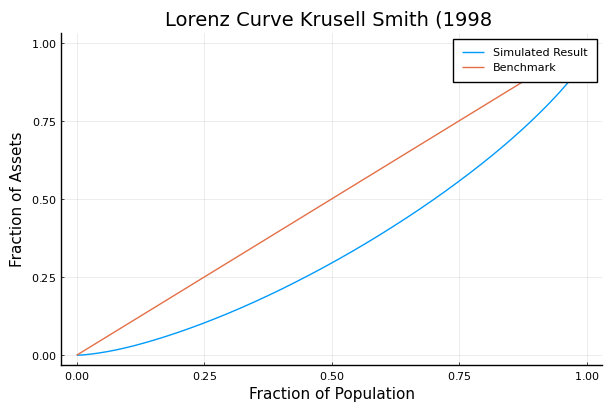

In [118]:
pyplot()
plot(xx,yy,  label = "Simulated Result")
plot!(xx,xx, label = "Benchmark")
xlabel!("Fraction of Population")
ylabel!("Fraction of Assets")
title!("Lorenz Curve Krusell Smith (1998 ")
savefig("/content/drive/MyDrive/Figure3_KS(1998).png")

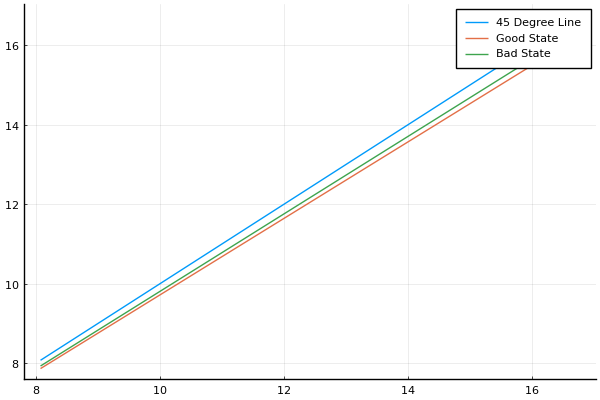

In [120]:
plot(Kgrid,Kgrid, label = "45 Degree Line")
plot!(Kgrid, (Coef[1,1] .+ Coef[1,2] * Kgrid) , label = "Good State")
plot!(Kgrid, (Coef[2,1] .+ Coef[2,2] * Kgrid) , label = "Bad State")

In [121]:
Ct = zeros(T);

In [122]:
for t = 2:T
    Yt[t] = Kt[t]^α * Lseq[t]^(1-α) * Zt[t]
    Ct[t] = Yt[t] +(1-δ) * Kt[t-1] - Kt[t]
end

In [124]:
Ct

3000-element Vector{Float64}:
 0.0
 0.8074672402329561
 0.8099419525874172
 0.8124224255330272
 0.8132633947239682
 0.8148921916793821
 0.8146221415998909
 0.8128389075510203
 0.8141900725048341
 0.8156495910786532
 0.8099378699985991
 0.8111056060334523
 0.7946811958375744
 ⋮
 0.836024867314249
 0.8347856107379297
 0.8326791812189978
 0.8316323545587689
 0.8297228198041022
 0.8262392370100589
 0.8258291131285329
 0.8227144515764166
 0.8201793007060676
 0.8191004062289995
 0.8131106979098881
 0.791312902566732

In [125]:
jldsave("/content/drive/MyDrive/Krusell_Smith_Original_Result.jld2"; 
GG, A_Ind, Kt, KKt , Ind_shock, zseq, Zt, Coef, Yt,Ct,agrid, Kgrid ) 

In [134]:
println("Maximum Error Level is ",abs.(Kt[2:end] - KKt[1:end-1])/ Kt[2:end] * 100 |> maximum, "Percent" )
println("Average Error Level is ",abs.(Kt[2:end] - KKt[1:end-1])/ Kt[2:end] * 100 |> mean, "Percent" )

Maximum Error Level is 0.00022451700487390519Percent
Average Error Level is 4.0299163187440233e-5Percent
